# Interpreting ResNet CIFAR-10 Training Process With Training Dynamics

This notebook trains a ResNet model using noisy CIFAR-10 dataset and employed Beyond Hand-Designed Feature(BHDF) algorithm, specifically `BHDFInterpreter`, to investigate and record the training dynamics. By establishing representation learning form training dynamics, BHDF proposes a dataset-transferable noise detector to identify the label noises in target datasets

In [1]:
import paddle
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import interpretdl as it

Define the training dataset using the CIFAR10 dataset generator from **paddle.vision.datasets**.

In [2]:
from paddle.vision.transforms import Transpose
from paddle.vision.datasets import Cifar10


class dataset(paddle.io.Dataset):
    """
    Modify output of getitem.
    
    :param :`paddle.io.Dataset`: base_dataset: Dataset to wrap

    """
    def __init__(self,
                 base_dataset: object):
        super().__init__()
        self.dataset = base_dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        input, target = self.dataset[index]
        return index, (input/255.0).astype(np.float32), int(target)

org_cifar10 = dataset(Cifar10(mode='train', transform=Transpose()))

Define a contaminated dataset given **original dataset**,**noise type** and **noise type**.

Initialize the ResNet50 model using **paddle.vision.models**.

In [3]:
from paddle.vision.models import resnet34
model = resnet34(pretrained=False, num_classes=10)

W0715 15:36:46.920593  4089 device_context.cc:447] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 10.2, Runtime API Version: 10.2
W0715 15:36:46.928239  4089 device_context.cc:465] device: 0, cuDNN Version: 7.6.


Set up a data loader with batch size of 128, and an Momentum optimizer for training.

**Note:** the data generator shoud be able to generate the index of each sample, the sample and its label, so that each sample's behavior can be recorded according to its index.

In [4]:
train_loader = paddle.io.DataLoader(org_cifar10, batch_size=128, shuffle=True,num_workers=4)
scheduler = paddle.optimizer.lr.MultiStepDecay(learning_rate=0.1, milestones=[100, 150], gamma=0.1)
optimizer = paddle.optimizer.SGD(learning_rate=scheduler, parameters=model.parameters())

First initialize the `TrainingDynamicsInterpreter` and then start `generator`ing the training process by training 200 epochs. 

*training_dynamics* is a dictionary that maps image index to each epoch's predictions in the training process; assigned_targets is list indicating the assigned targets (maybe noisy) for each sample. They are saved at "assets/training_dynamics.npz" as default.

In [5]:
TDI = it.TrainingDynamics(model, device='gpu:0')

epochs = 200
print('Training %d epochs. This may take some time.' % epochs)
training_dynamics = TDI.generator(
                  train_loader=train_loader,
                  optimizer=optimizer,
                  epochs=epochs,              
)

In [6]:
TDI.save(training_dynamics,assigned_targets,label_flip=None,save_path='assets')

# predict and rank

With help of representation learning from time-series data, a two-layer LSTM model can be instanced as a noise detector to identify the underlying label noise in CIFAR-10 dataset  

In [7]:
class LSTM_detector(paddle.nn.Layer):
    def __init__(self,input_size=1,hidden_size=64,num_layers=2):
        super(LSTM_detector, self).__init__()
        
        # maybe need initialisation
        self.classifier = paddle.nn.Linear(in_features=hidden_size,out_features=2)
        self.softmax = paddle.nn.Softmax()
        self.lstm = paddle.nn.LSTM(input_size=input_size, 
                                   hidden_size=hidden_size, 
                                   num_layers=num_layers,
                                   time_major=False,)
    def forward(self, x):
        if len(x.shape) !=3:
            x = paddle.unsqueeze(x,axis=2)
        out, (_, _) = self.lstm(x)
        out = self.classifier(out[:,-1,:])
        out = self.softmax(out)
        return out

BHDF = it.BHDFinterpreter(LSTM_detector(), device='gpu:0')
order,predictions = BHDF.interpret(training_dynamics_path="assets/training_dynamics.npz",
               detector_model_path="assets/noise_detector_trained")

# visulization

Text(0.5, 1.0, 'Distribution Of Predictions')

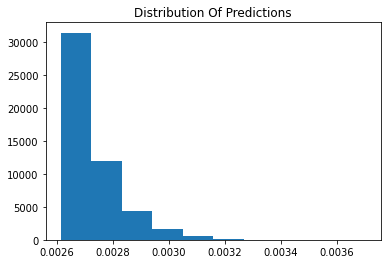

In [8]:
plt.hist(predictions)
plt.title("Distribution Of Predictions")

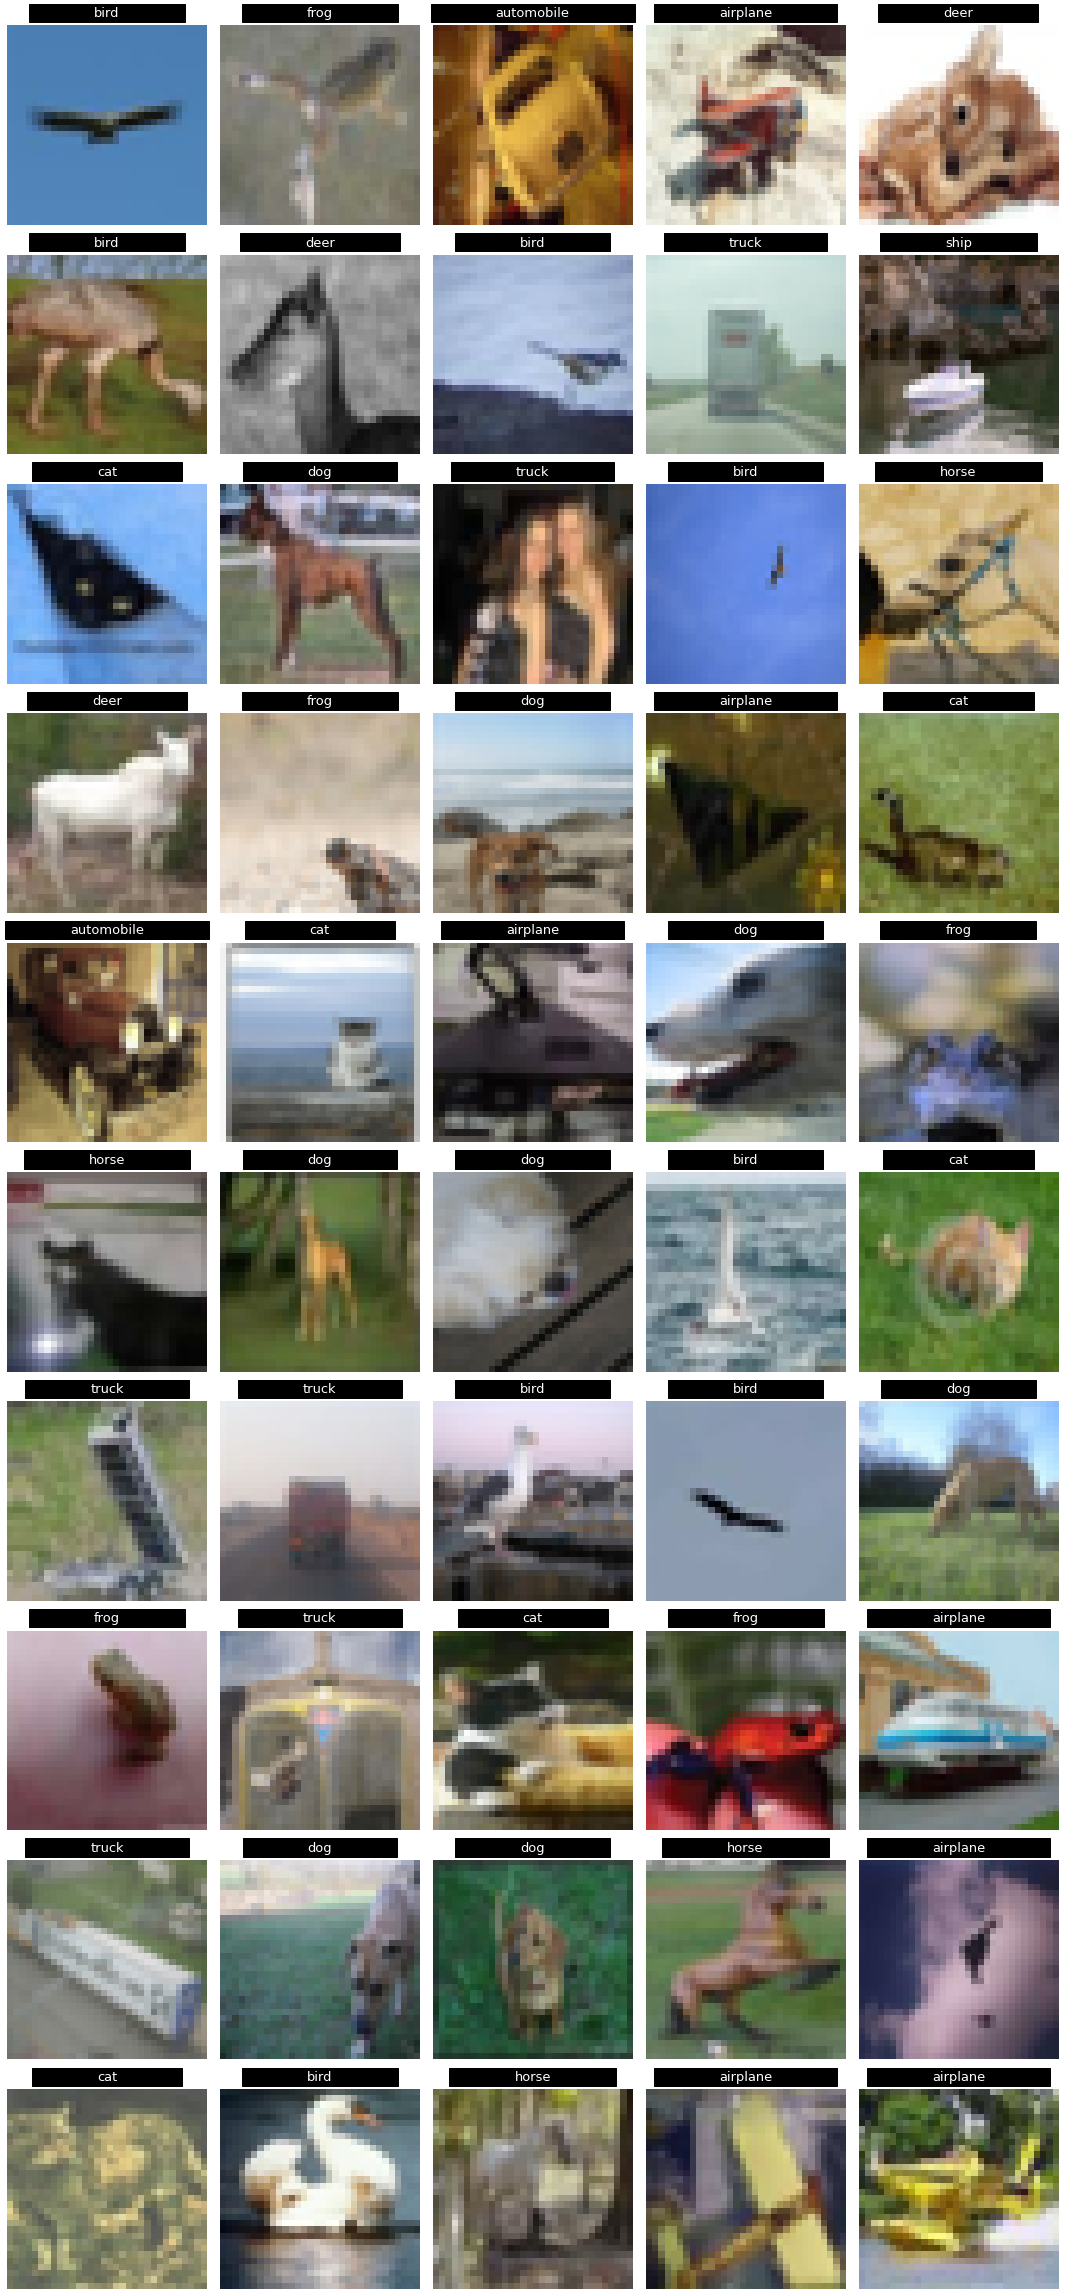

In [ ]:
def showsomesamples(train_dataset,indices,names):
    
    index = indices[i]
    image = train_dataset.__getitem__(index)[0].transpose(1,2,0)
    label = train_dataset.__getitem__(index)[1].item()

    ax=fig.add_subplot(rows, columns, i+1)
    plt.imshow(image)
    plt.axis('off')

    title = ax.set_title(names[label], fontsize=13,position=(.5, 1),
             backgroundcolor='black', color='white',
             verticalalignment="bottom", horizontalalignment="center")
    title._bbox_patch._mutation_aspect = 0.04
    title.get_bbox_patch().set_boxstyle("square", pad=5)
    plt.tight_layout()
    
#top 50
rows = 10
columns = 5
labeldict={0:'airplane',
           1:'automobile',
           2:'bird',
           3:'cat',
           4:'deer',
           5:'dog',
           6:'frog',
           7:'horse',
           8:'ship',
           9:'truck'}

fig = plt.figure(figsize=(3*columns, 3.2*rows))
for i in range(rows*columns):
    showsomesamples(org_cifar10.dataset,np.flip(order[-rows*columns:]),labeldict)